In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import albumentations as A
import time
from sklearn.model_selection import StratifiedKFold

In [2]:
X = joblib.load("converted_img.pkl")
y = joblib.load("label.pkl")

To pass an image to the augmentation pipeline you need to call the transform function created by a call to A.Compose at Step 2. In the image argument to that function, you need to pass an image that you want to augment.

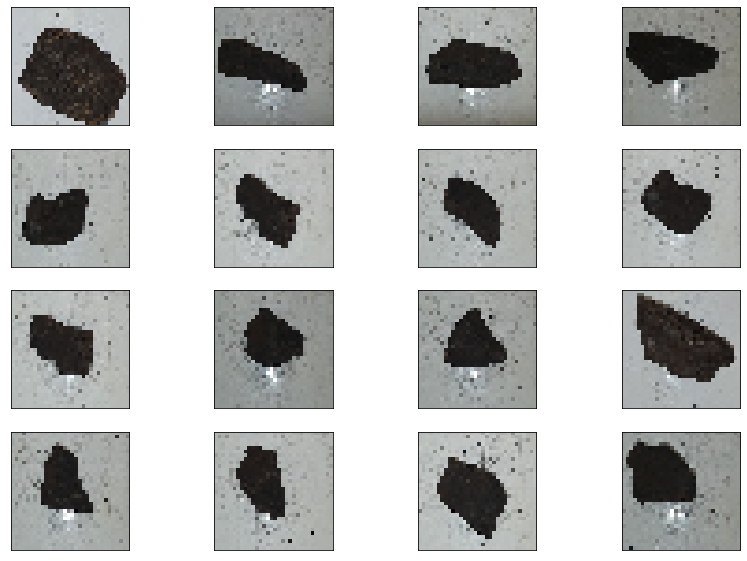

In [3]:
fig = plt.figure(figsize=(14, 10))
for i in range(1, 17):
    ax = plt.subplot(4, 4, i)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(X[i])

In [4]:
X = np.float32(X)

In [5]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y.reshape(-1, 1))

OneHotEncoder(sparse=False)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)
y_test = encoder.transform(y_test.reshape(-1, 1))
# y_train = encoder.transform(y_train.reshape(-1, 1))

test_trainsform = A.Compose([
A.Resize(32, 32)
])

img_list=[]
for i in range(len(X_test)):
    img_list.append(test_trainsform(image=X_test[i])["image"])
img_list = np.float32(img_list)
X_test = img_list

In [7]:
transform_crop = A.Compose([
    A.Resize(40, 40),
    A.RandomCrop(32, 32),
    A.OneOf([
    A.HorizontalFlip(p=1), 
    A.VerticalFlip(p=1)],p=1)
])

In [8]:
transform_flip_bright = A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=0.5),
    A.RandomBrightness(p=0.5, limit=(-0.25, 0.25))
])

C:\Users\hjhhi\anaconda3\envs\python3.9.0\lib\site-packages\albumentations\augmentations\transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [9]:
transform_fiip = A.Compose([
    A.Resize(32, 32),
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=0.5),
])

In [10]:
temp=[]
for _ in range(8):
    temp.append(transform_crop(image=X_train[0])["image"])

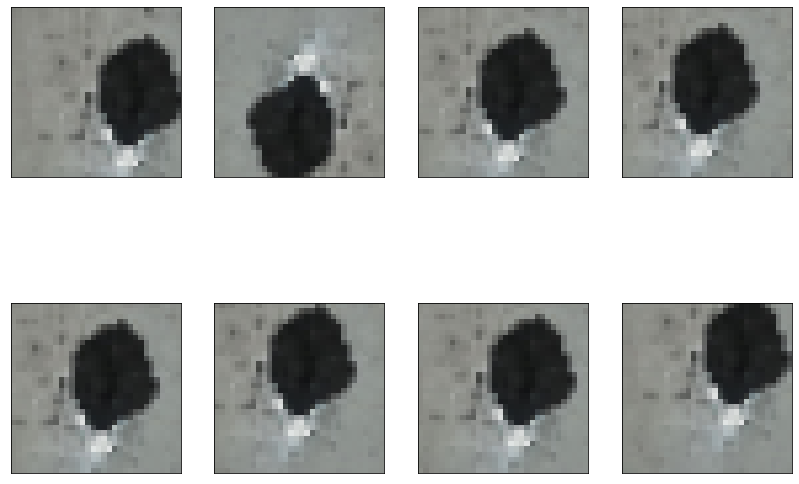

In [11]:
fig = plt.figure(figsize=(14, 10))
for i in range(1, 9):
    ax = plt.subplot(2, 4, i)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(temp[i-1])

In [12]:
temp=[]
for _ in range(8):
    temp.append(transform_fiip(image=X_train[0])["image"])

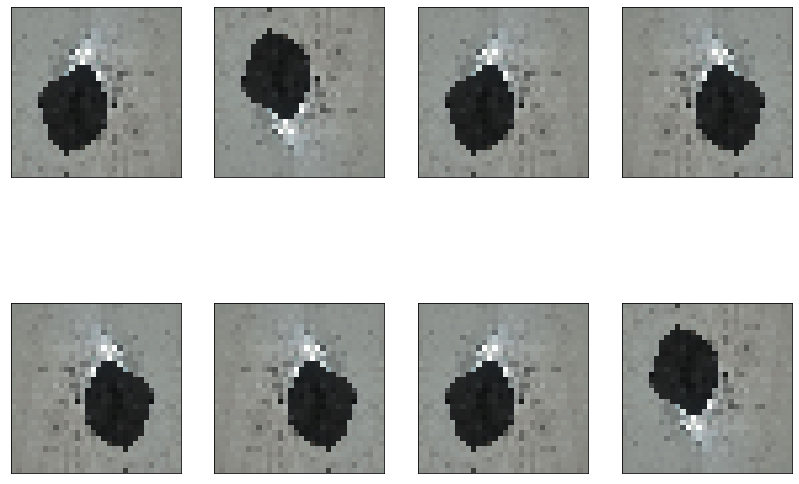

In [13]:
fig = plt.figure(figsize=(14, 10))
for i in range(1, 9):
    ax = plt.subplot(2, 4, i)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(temp[i-1])

In [14]:
temp=[]
for _ in range(8):
    temp.append(transform_flip_bright(image=X_train[0])["image"])

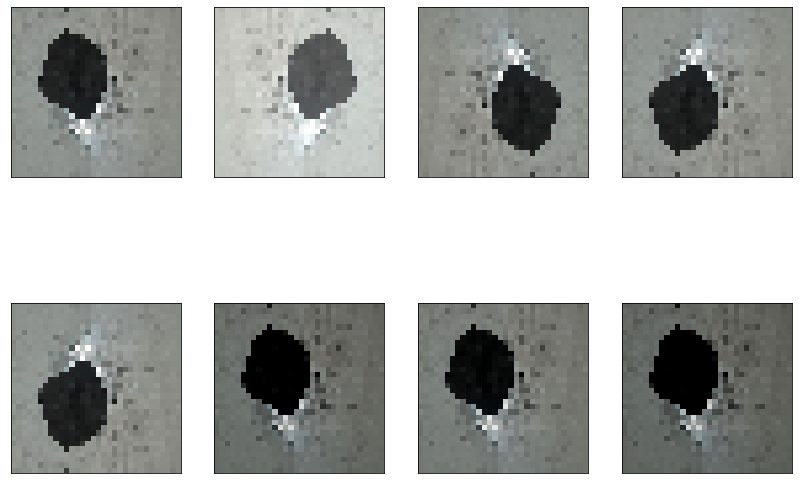

In [15]:
fig = plt.figure(figsize=(14, 10))
for i in range(1, 9):
    ax = plt.subplot(2, 4, i)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(temp[i-1])

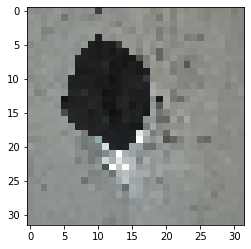

In [17]:
plt.imshow(X_train[0])

In [18]:
def make_train_data(augment):
    img_list = []
    label_list = []
    for _ in range(10):
        for i in range(len(X_train)):
            img_list.append(augment(image=X_train[i])["image"])
            label_list.append(y_train[i])
    img_list = np.float32(img_list)
    img_list = img_list.reshape(-1, 32, 32, 3)
    label_list = np.float32(label_list)
    return [img_list, label_list]

# Augmentation model

In [19]:
es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, mode="max")

In [20]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.00001, verbose=1)

In [33]:
history_list=[]

for i in [transform_crop, transform_fiip, transform_flip_bright]:
    X_train_, y_train_ = make_train_data(i)
    y_train_ = y_train_.reshape(-1, 1)
    y_train_ = encoder.transform(y_train_)
    
    dr_ratio=0.2

    Input = keras.layers.Input(shape=X_train_[0].shape)

    x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)

    shortcut =x
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x   = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)


    x = keras.layers.Dropout(dr_ratio)(x)


    shortcut =x
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)

    shortcut =x
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)


    x = keras.layers.GlobalAveragePooling2D()(x)
    Output = keras.layers.Dense(4, activation="softmax")(x)

    model = keras.models.Model(inputs = Input, outputs = Output)
    model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

    history_list.append(model.fit(X_train_, y_train_, validation_data=(X_test, y_test),callbacks=[es, reduce_lr],epochs = 100))
    print("Train: ", model.evaluate(X_train_, y_train_))
    print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
1707/1707 [==============================] - 22s 12ms/step - loss: 0.4729 - accuracy: 0.8079 - val_loss: 5.2093 - val_accuracy: 0.3973
Epoch 2/100
1707/1707 [==============================] - 20s 12ms/step - loss: 0.2166 - accuracy: 0.9171 - val_loss: 2.1435 - val_accuracy: 0.5896
Epoch 3/100
1707/1707 [==============================] - 20s 12ms/step - loss: 0.1506 - accuracy: 0.9439 - val_loss: 2.5714 - val_accuracy: 0.5308
Epoch 4/100
1707/1707 [==============================] - 20s 12ms/step - loss: 0.1129 - accuracy: 0.9586 - val_loss: 2.2028 - val_accuracy: 0.5533
Epoch 5/100
1707/1707 [==============================] - 20s 12ms/step - loss: 0.0912 - accuracy: 0.9669 - val_loss: 3.3970 - val_accuracy: 0.5126

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/100
1707/1707 [==============================] - 20s 12ms/step - loss: 0.0497 - accuracy: 0.9821 - val_loss: 2.5057 - val_accuracy: 0.5571
Epoch 7/100
1707/1707 [==============

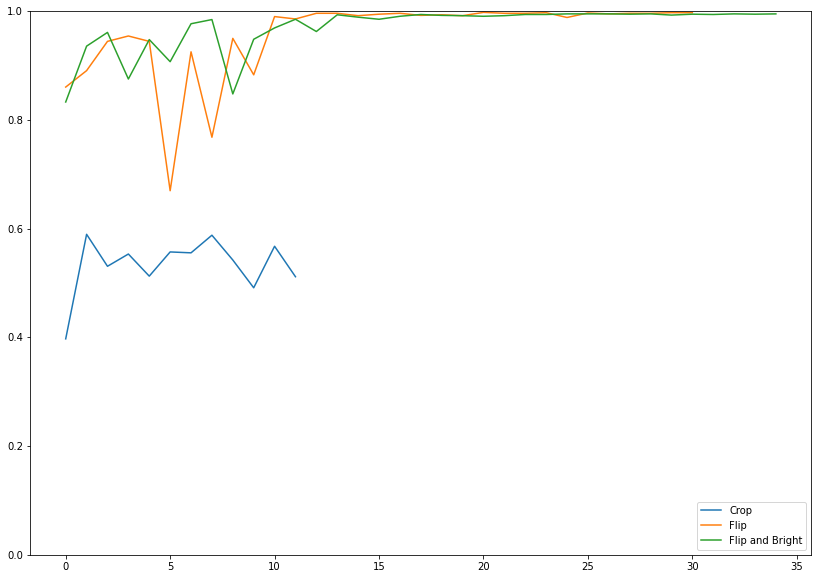

In [34]:
plt.figure(figsize=(14, 10))
for i,k in enumerate(["Crop", "Flip", "Flip and Bright"]):
    plt.ylim(0.0, 1)
    plt.plot(history_list[i].history["val_accuracy"], label=str(k))
plt.legend(loc="lower right")

# Original data model

In [40]:
X = joblib.load("CV2_float32.pkl")

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

In [42]:
y_train = encoder.transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

In [44]:
dr_ratio=0.2

Input = keras.layers.Input(shape=X_train[0].shape)

x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(dr_ratio)(x)

shortcut =x
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x   = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)


x = keras.layers.Dropout(dr_ratio)(x)


shortcut =x
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(dr_ratio)(x)

shortcut =x
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(dr_ratio)(x)


x = keras.layers.GlobalAveragePooling2D()(x)
Output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.models.Model(inputs = Input, outputs = Output)
model.compile(loss="categorical_crossentropy",
optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

history=model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es, reduce_lr],epochs = 100)
print("Train: ", model.evaluate(X_train, y_train))
print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
171/171 [==============================] - 4s 14ms/step - loss: 0.8848 - accuracy: 0.6130 - val_loss: 10.2770 - val_accuracy: 0.1835
Epoch 2/100
171/171 [==============================] - 2s 12ms/step - loss: 0.6602 - accuracy: 0.7236 - val_loss: 4.9144 - val_accuracy: 0.2324
Epoch 3/100
171/171 [==============================] - 2s 12ms/step - loss: 0.5420 - accuracy: 0.7722 - val_loss: 2.2591 - val_accuracy: 0.4055
Epoch 4/100
171/171 [==============================] - 2s 13ms/step - loss: 0.4537 - accuracy: 0.8165 - val_loss: 0.7795 - val_accuracy: 0.7319
Epoch 5/100
171/171 [==============================] - 2s 12ms/step - loss: 0.3676 - accuracy: 0.8474 - val_loss: 0.7772 - val_accuracy: 0.7110
Epoch 6/100
171/171 [==============================] - 2s 12ms/step - loss: 0.2974 - accuracy: 0.8864 - val_loss: 2.0202 - val_accuracy: 0.5236
Epoch 7/100
171/171 [==============================] - 2s 12ms/step - loss: 0.2542 - accuracy: 0.9062 - val_loss: 1.2344 - val_accuracy

##  Save history list

In [78]:
hist_list = []
for i in range(3):
    hist_list.append(history_list[1].history)
joblib.dump(hist_list, "history_list.pkl")

['history_list.pkl']

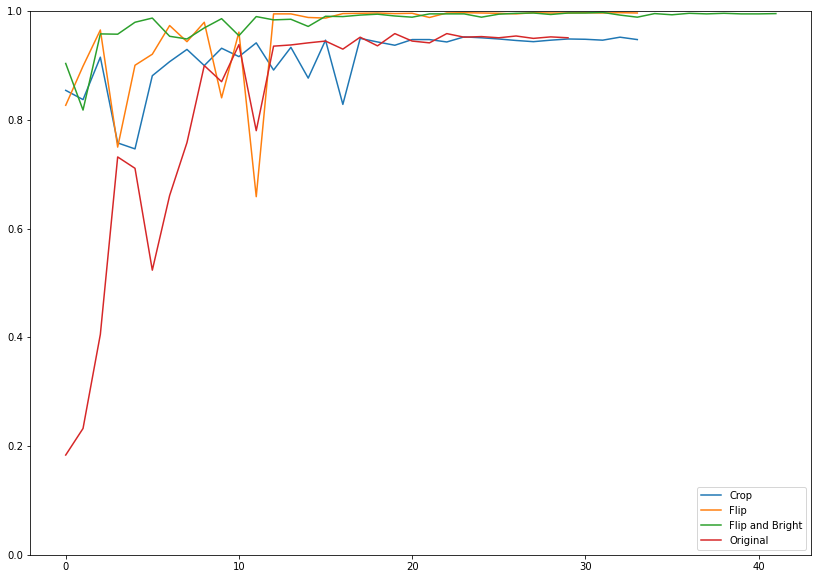

In [50]:
plt.figure(figsize=(14, 10))
for i,k in enumerate(["Crop", "Flip", "Flip and Bright"]):
    plt.ylim(0.0, 1)
    plt.plot(history_list[i].history["val_accuracy"], label=str(k))
plt.plot(history.history["val_accuracy"], label="Original")
plt.legend(loc="lower right")

In [51]:
history_list[1].history["val_accuracy"]

[0.8269230723381042,
 0.898901104927063,
 0.9653846025466919,
 0.75,
 0.9005494713783264,
 0.9208791255950928,
 0.9736263751983643,
 0.9439560174942017,
 0.9796703457832336,
 0.8406593203544617,
 0.9615384340286255,
 0.658791184425354,
 0.9950549602508545,
 0.9950549602508545,
 0.9884615540504456,
 0.9873626232147217,
 0.995604395866394,
 0.9961538314819336,
 0.9967032670974731,
 0.995604395866394,
 0.9961538314819336,
 0.9884615540504456,
 0.9967032670974731,
 0.9972527623176575,
 0.9967032670974731,
 0.9961538314819336,
 0.9950549602508545,
 0.9972527623176575,
 0.9967032670974731,
 0.9967032670974731,
 0.9972527623176575,
 0.9967032670974731,
 0.9972527623176575,
 0.9967032670974731]

In [52]:
history_list[2].history["val_accuracy"]

[0.9038461446762085,
 0.8181318640708923,
 0.9582417607307434,
 0.9576923251152039,
 0.9796703457832336,
 0.9873626232147217,
 0.9538461565971375,
 0.9489011168479919,
 0.9692307710647583,
 0.9862637519836426,
 0.9549450278282166,
 0.9901098608970642,
 0.9840659499168396,
 0.9851648211479187,
 0.9719780087471008,
 0.9906593561172485,
 0.9901098608970642,
 0.9928571581840515,
 0.9945054650306702,
 0.9912087917327881,
 0.9890109896659851,
 0.9950549602508545,
 0.9950549602508545,
 0.9950549602508545,
 0.9890109896659851,
 0.9945054650306702,
 0.9961538314819336,
 0.9967032670974731,
 0.9939560294151306,
 0.9967032670974731,
 0.9967032670974731,
 0.997802197933197,
 0.9928571581840515,
 0.9890109896659851,
 0.995604395866394,
 0.9934065937995911,
 0.9961538314819336,
 0.9950549602508545,
 0.9961538314819336,
 0.9950549602508545,
 0.9950549602508545,
 0.995604395866394]

In [14]:
history_list_2=[]

for i in [transform_crop, transform_fiip, transform_flip_bright]:
    X_train_, y_train_ = make_train_data(i)
    y_train_ = y_train_.reshape(-1, 1)
    y_train_ = encoder.transform(y_train_)
    
    dr_ratio=0.1

    Input = keras.layers.Input(shape=X_train_[0].shape)

    x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)

    shortcut =x
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x   = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)


    x = keras.layers.Dropout(dr_ratio)(x)


    shortcut =x
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)

    shortcut =x
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)


    x = keras.layers.GlobalAveragePooling2D()(x)
    Output = keras.layers.Dense(4, activation="softmax")(x)

    model = keras.models.Model(inputs = Input, outputs = Output)
    model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

    history_list_2.append(model.fit(X_train_, y_train_, validation_data=(X_test, y_test),callbacks=[es, reduce_lr],epochs = 100))
    print("Train: ", model.evaluate(X_train_, y_train_))
    print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
1707/1707 [==============================] - 20s 11ms/step - loss: 0.3704 - accuracy: 0.8510 - val_loss: 1.3175 - val_accuracy: 0.6599
Epoch 2/100
1707/1707 [==============================] - 19s 11ms/step - loss: 0.1601 - accuracy: 0.9404 - val_loss: 0.4955 - val_accuracy: 0.8434
Epoch 3/100
1707/1707 [==============================] - 19s 11ms/step - loss: 0.1082 - accuracy: 0.9597 - val_loss: 0.2607 - val_accuracy: 0.9016
Epoch 4/100
1707/1707 [==============================] - 19s 11ms/step - loss: 0.0797 - accuracy: 0.9703 - val_loss: 0.3974 - val_accuracy: 0.8857
Epoch 5/100
1707/1707 [==============================] - 19s 11ms/step - loss: 0.0632 - accuracy: 0.9775 - val_loss: 0.5916 - val_accuracy: 0.7918
Epoch 6/100
1707/1707 [==============================] - 19s 11ms/step - loss: 0.0507 - accuracy: 0.9821 - val_loss: 1.4874 - val_accuracy: 0.7176

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
1707/1707 [==============

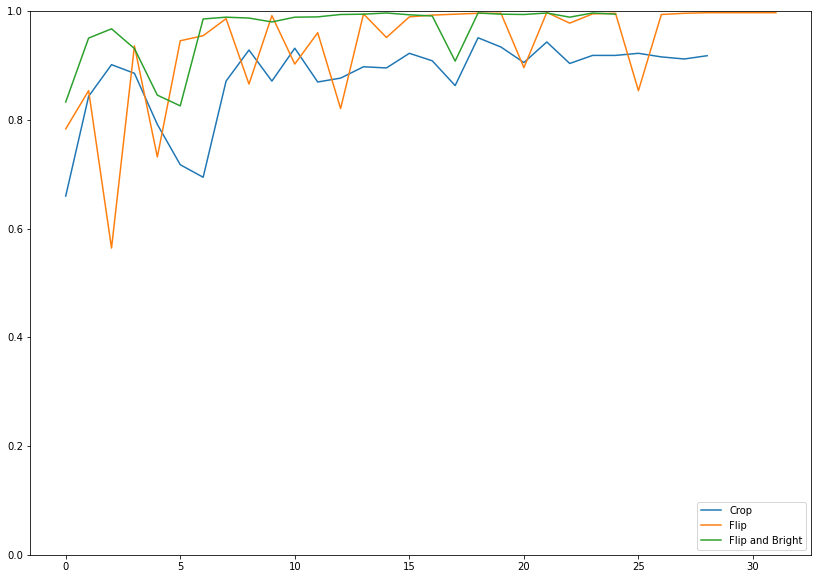

In [15]:
plt.figure(figsize=(14, 10))
for i,k in enumerate(["Crop", "Flip", "Flip and Bright"]):
    plt.ylim(0.0, 1)
    plt.plot(history_list_2[i].history["val_accuracy"], label=str(k))
plt.legend(loc="lower right")

In [16]:
history_list_2[1].history["val_accuracy"]

[0.7835164666175842,
 0.8538461327552795,
 0.5642856955528259,
 0.9362637400627136,
 0.7318681478500366,
 0.9456043839454651,
 0.9549450278282166,
 0.9862637519836426,
 0.8659340739250183,
 0.9917582273483276,
 0.9027472734451294,
 0.9604395627975464,
 0.8208791017532349,
 0.9950549602508545,
 0.9516483545303345,
 0.9895604252815247,
 0.9928571581840515,
 0.9945054650306702,
 0.9961538314819336,
 0.9961538314819336,
 0.8961538672447205,
 0.997802197933197,
 0.9780219793319702,
 0.9950549602508545,
 0.9961538314819336,
 0.8538461327552795,
 0.9939560294151306,
 0.9961538314819336,
 0.9972527623176575,
 0.9972527623176575,
 0.9972527623176575,
 0.9972527623176575]

In [17]:
history_list_2[2].history["val_accuracy"]

[0.8329670429229736,
 0.9505494236946106,
 0.9675824046134949,
 0.9313187003135681,
 0.845604419708252,
 0.8258242011070251,
 0.9857142567634583,
 0.9890109896659851,
 0.9873626232147217,
 0.9802197813987732,
 0.9890109896659851,
 0.9895604252815247,
 0.9939560294151306,
 0.9945054650306702,
 0.9967032670974731,
 0.9934065937995911,
 0.9912087917327881,
 0.9082417488098145,
 0.9967032670974731,
 0.9945054650306702,
 0.9939560294151306,
 0.9967032670974731,
 0.9890109896659851,
 0.9967032670974731,
 0.9945054650306702]

In [18]:
history_list_3=[]

for i in [transform_crop, transform_fiip, transform_flip_bright]:
    X_train_, y_train_ = make_train_data(i)
    y_train_ = y_train_.reshape(-1, 1)
    y_train_ = encoder.transform(y_train_)
    
    dr_ratio=0.4

    Input = keras.layers.Input(shape=X_train_[0].shape)

    x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)

    shortcut =x
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x   = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)


    x = keras.layers.Dropout(dr_ratio)(x)


    shortcut =x
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)

    shortcut =x
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)


    x = keras.layers.GlobalAveragePooling2D()(x)
    Output = keras.layers.Dense(4, activation="softmax")(x)

    model = keras.models.Model(inputs = Input, outputs = Output)
    model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

    history_list_3.append(model.fit(X_train_, y_train_, validation_data=(X_test, y_test),callbacks=[es, reduce_lr],epochs = 100))
    print("Train: ", model.evaluate(X_train_, y_train_))
    print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
1707/1707 [==============================] - 20s 11ms/step - loss: 0.5724 - accuracy: 0.7607 - val_loss: 0.3927 - val_accuracy: 0.8538
Epoch 2/100
1707/1707 [==============================] - 19s 11ms/step - loss: 0.2945 - accuracy: 0.8872 - val_loss: 4.8875 - val_accuracy: 0.3698
Epoch 3/100
1707/1707 [==============================] - 19s 11ms/step - loss: 0.2087 - accuracy: 0.9221 - val_loss: 1.4812 - val_accuracy: 0.6769
Epoch 4/100
1707/1707 [==============================] - 19s 11ms/step - loss: 0.1676 - accuracy: 0.9377 - val_loss: 1.0096 - val_accuracy: 0.7571

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/100
1707/1707 [==============================] - 18s 11ms/step - loss: 0.1150 - accuracy: 0.9566 - val_loss: 2.0526 - val_accuracy: 0.5852
Epoch 6/100
1707/1707 [==============================] - 18s 11ms/step - loss: 0.0983 - accuracy: 0.9652 - val_loss: 0.4519 - val_accuracy: 0.8846
Epoch 7/100
1707/1707 [==============

1707/1707 [==============================] - 19s 11ms/step - loss: 0.0266 - accuracy: 0.9905 - val_loss: 0.6068 - val_accuracy: 0.8473
Epoch 19/100
1707/1707 [==============================] - 19s 11ms/step - loss: 0.0240 - accuracy: 0.9914 - val_loss: 0.5342 - val_accuracy: 0.8643
Epoch 20/100
1707/1707 [==============================] - 20s 11ms/step - loss: 0.0248 - accuracy: 0.9912 - val_loss: 0.7959 - val_accuracy: 0.8198

Epoch 00020: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 21/100
1707/1707 [==============================] - 8s 5ms/step - loss: 0.8493 - accuracy: 0.8290
Train:  [0.8493371605873108, 0.8289743661880493]
57/57 [==============================] - 0s 5ms/step - loss: 0.9529 - accuracy: 0.8011
Valid:  [0.9528970122337341, 0.8010988831520081]


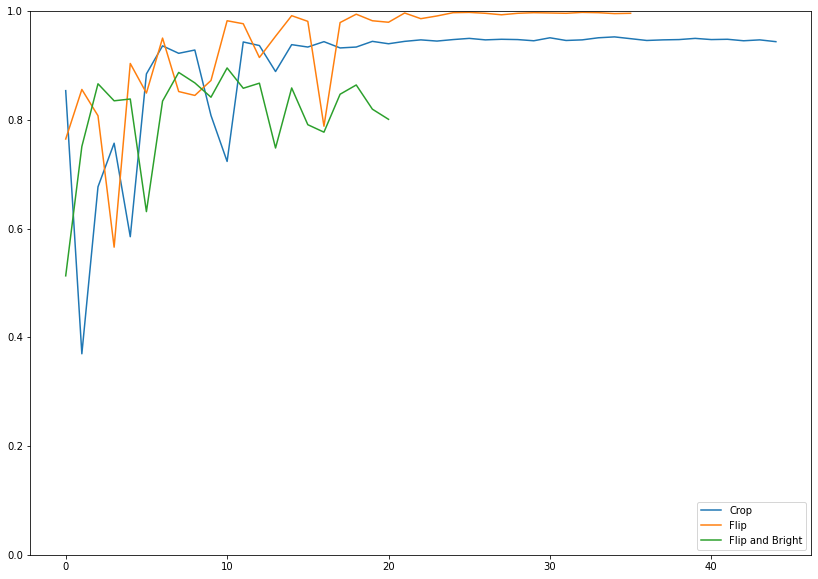

In [19]:
plt.figure(figsize=(14, 10))
for i,k in enumerate(["Crop", "Flip", "Flip and Bright"]):
    plt.ylim(0.0, 1)
    plt.plot(history_list_3[i].history["val_accuracy"], label=str(k))
plt.legend(loc="lower right")

In [20]:
history_list_3[1].history["val_accuracy"]

[0.7648351788520813,
 0.8560439348220825,
 0.807692289352417,
 0.5659340620040894,
 0.9038461446762085,
 0.8494505286216736,
 0.9505494236946106,
 0.8521978259086609,
 0.8450549244880676,
 0.8725274801254272,
 0.9824175834655762,
 0.9769230484962463,
 0.9148351550102234,
 0.9538461565971375,
 0.9917582273483276,
 0.9813186526298523,
 0.7884615659713745,
 0.9791208505630493,
 0.9945054650306702,
 0.9824175834655762,
 0.9796703457832336,
 0.9967032670974731,
 0.9862637519836426,
 0.9912087917327881,
 0.9972527623176575,
 0.997802197933197,
 0.9961538314819336,
 0.9934065937995911,
 0.9961538314819336,
 0.9972527623176575,
 0.9967032670974731,
 0.9961538314819336,
 0.997802197933197,
 0.9972527623176575,
 0.995604395866394,
 0.9961538314819336]

In [21]:
history_list_3[2].history["val_accuracy"]

[0.5131868124008179,
 0.7510989308357239,
 0.8664835095405579,
 0.8351648449897766,
 0.8384615182876587,
 0.6313186883926392,
 0.8346154093742371,
 0.8873626589775085,
 0.8681318759918213,
 0.8417582511901855,
 0.8956043720245361,
 0.8582417368888855,
 0.8675824403762817,
 0.7483516335487366,
 0.8587912321090698,
 0.791208803653717,
 0.7774725556373596,
 0.8472527265548706,
 0.8642857074737549,
 0.8197802305221558,
 0.8010988831520081]

In [34]:
history_list_4=[]

for i in [transform_crop, transform_fiip, transform_flip_bright]:
    X_train_, y_train_ = make_train_data(i)
    y_train_ = y_train_.reshape(-1, 1)
    y_train_ = encoder.transform(y_train_)
    

    Input = keras.layers.Input(shape=X_train_[0].shape)

    x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)


    shortcut =x
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x   = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)




    shortcut =x
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)


    shortcut =x
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)



    x = keras.layers.GlobalAveragePooling2D()(x)
    Output = keras.layers.Dense(4, activation="softmax")(x)

    model = keras.models.Model(inputs = Input, outputs = Output)
    model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

    history_list_4.append(model.fit(X_train_, y_train_, validation_data=(X_test, y_test),callbacks=[es, reduce_lr],epochs = 100))
    print("Train: ", model.evaluate(X_train_, y_train_))
    print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
1707/1707 [==============================] - 19s 10ms/step - loss: 0.3505 - accuracy: 0.8600 - val_loss: 0.6590 - val_accuracy: 0.7863
Epoch 2/100
1707/1707 [==============================] - 17s 10ms/step - loss: 0.1381 - accuracy: 0.9505 - val_loss: 0.3956 - val_accuracy: 0.8797
Epoch 3/100
1707/1707 [==============================] - 18s 10ms/step - loss: 0.0834 - accuracy: 0.9701 - val_loss: 0.7916 - val_accuracy: 0.7769
Epoch 4/100
1707/1707 [==============================] - 18s 10ms/step - loss: 0.0606 - accuracy: 0.9784 - val_loss: 0.6228 - val_accuracy: 0.8280
Epoch 5/100
1707/1707 [==============================] - 18s 10ms/step - loss: 0.0473 - accuracy: 0.9828 - val_loss: 0.2751 - val_accuracy: 0.9093
Epoch 6/100
1707/1707 [==============================] - 18s 11ms/step - loss: 0.0354 - accuracy: 0.9874 - val_loss: 1.3578 - val_accuracy: 0.7236
Epoch 7/100
1707/1707 [==============================] - 19s 11ms/step - loss: 0.0320 - accuracy: 0.9882 - val_loss: 1

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

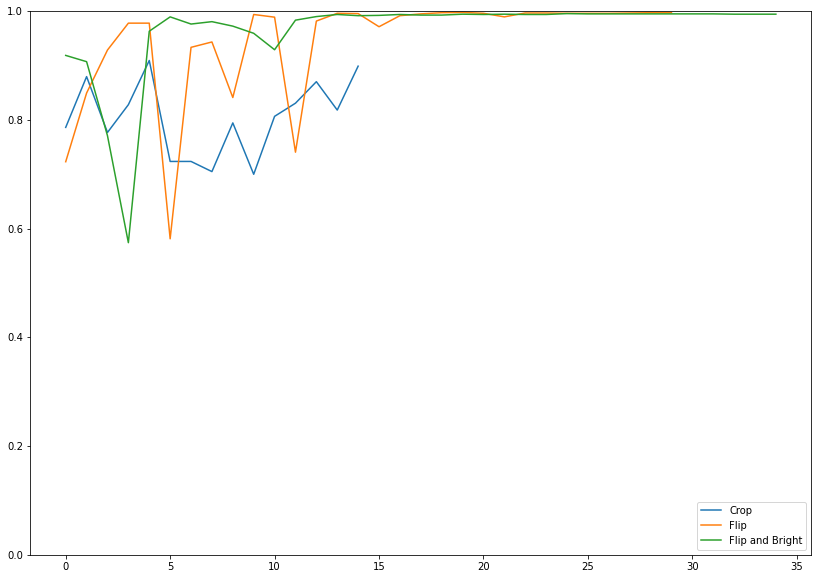

In [35]:
plt.figure(figsize=(14, 10))
for i,k in enumerate(["Crop", "Flip", "Flip and Bright"]):
    plt.ylim(0.0, 1)
    plt.plot(history_list_4[i].history["val_accuracy"], label=str(k))
plt.legend(loc="lower right")

In [36]:
history_list_4[1].history["val_accuracy"]

[0.7230769395828247,
 0.8494505286216736,
 0.9285714030265808,
 0.9780219793319702,
 0.9780219793319702,
 0.5813186764717102,
 0.9335165023803711,
 0.9434065818786621,
 0.841208815574646,
 0.9939560294151306,
 0.9890109896659851,
 0.7406593561172485,
 0.9818681478500366,
 0.9961538314819336,
 0.995604395866394,
 0.9714285731315613,
 0.9917582273483276,
 0.9950549602508545,
 0.9972527623176575,
 0.997802197933197,
 0.9961538314819336,
 0.9895604252815247,
 0.9967032670974731,
 0.9967032670974731,
 0.9961538314819336,
 0.9961538314819336,
 0.9961538314819336,
 0.9967032670974731,
 0.9972527623176575,
 0.9972527623176575]

In [37]:
history_list_4[2].history["val_accuracy"]

[0.9186813235282898,
 0.9071428775787354,
 0.7708791494369507,
 0.5741758346557617,
 0.9631868004798889,
 0.9895604252815247,
 0.9763736128807068,
 0.9807692170143127,
 0.9725274443626404,
 0.9593406319618225,
 0.9291208982467651,
 0.9835164546966553,
 0.9901098608970642,
 0.9939560294151306,
 0.9917582273483276,
 0.9923076629638672,
 0.9939560294151306,
 0.9928571581840515,
 0.9928571581840515,
 0.9945054650306702,
 0.9939560294151306,
 0.9945054650306702,
 0.9939560294151306,
 0.9939560294151306,
 0.995604395866394,
 0.9950549602508545,
 0.9950549602508545,
 0.9950549602508545,
 0.9950549602508545,
 0.9950549602508545,
 0.9950549602508545,
 0.9950549602508545,
 0.9945054650306702,
 0.9945054650306702,
 0.9945054650306702]

In [38]:
hist_list = joblib.load("history_list.pkl")

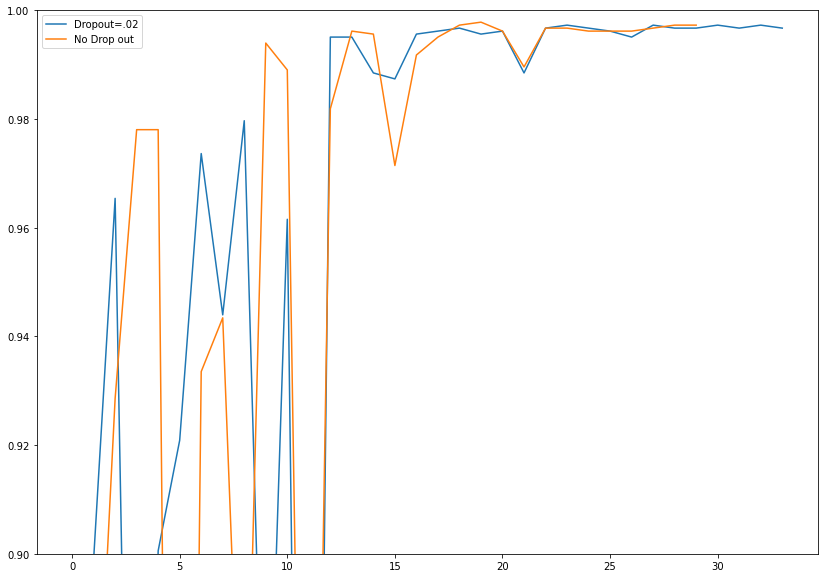

In [43]:
plt.figure(figsize=(14, 10))
plt.plot(hist_list[1]["val_accuracy"], label="Dropout=.02")
plt.plot(history_list_4[1].history["val_accuracy"], label="No Drop out")
plt.ylim(0.9, 1)
plt.legend()

# Validation by K-fold

In [58]:
def make_model(X_train_, y_train_,X_test, y_test, dr_ratio=0.2):
    dr_ratio=0.4

    Input = keras.layers.Input(shape=X_train_[0].shape)

    x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)

    shortcut =x
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x   = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)


    x = keras.layers.Dropout(dr_ratio)(x)


    shortcut =x
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)

    shortcut =x
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
    shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool2D(2)(x)

    x = keras.layers.Dropout(dr_ratio)(x)


    x = keras.layers.GlobalAveragePooling2D()(x)
    Output = keras.layers.Dense(4, activation="softmax")(x)

    model = keras.models.Model(inputs = Input, outputs = Output)
    model.compile(loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

    history = model.fit(X_train_, y_train_, validation_data=(X_test, y_test),callbacks=[es, reduce_lr],epochs = 100, verbose=0)
    print("Train: ", model.evaluate(X_train_, y_train_))
    print("Valid: ", model.evaluate(X_test, y_test))

In [72]:
X_train, y_train = make_train_data(transform_fiip)

In [73]:
fold = StratifiedKFold(n_splits=5, shuffle=True)
fold.get_n_splits(X_train, y_train)

5

In [76]:
for train_index, test_index in fold.split(X_train, y_train):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train_, X_test_ = X_train[train_index], X_train[test_index]
    y_train_, y_test_ = y_train[train_index], y_train[test_index]
#     print("Train label:n {}. Test label:\n {}".format(pd.Series(y_train).value_counts(), pd.Series(y_train).value_counts()))
    y_train_ = encoder.transform(y_train_.reshape(-1, 1))
    y_test_ = encoder.transform(y_test_.reshape(-1, 1))

    make_model(X_train_, y_train_, X_test_, y_test_)


Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
1365/1365 [==============================] - 6s 5ms/step - loss: 2.7597e-04 - accuracy: 1.0000
Train:  [0.00027596583822742105, 0.9999542236328125]
342/342 [==============================] - 2s 5ms/step - loss: 9.3021e-04 - accuracy: 0.9995: 0s - l
Valid:  [0.0009302059188485146, 0.9995421171188354]

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00021: ReduceLROnPlateau reducing learning ra

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [75]:
y_test_.shape

(10920,)

# Test by many library images

In [21]:
X_train = []
X_test = []
y_train = []
y_test =[]

X = joblib.load("CV2_float32.pkl")
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)
X_train.append(X_train_), y_train.append(y_train_), X_test.append(X_test_), y_test.append(y_test_)

X = joblib.load("converted_img.pkl")
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)
X_train.append(X_train_), y_train.append(y_train_), X_test.append(X_test_), y_test.append(y_test_)

X = joblib.load("CV2_LANCZO.pkl")
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)
X_train.append(X_train_), y_train.append(y_train_), X_test.append(X_test_), y_test.append(y_test_)

X_train = np.float32(X_train)
X_test = np.float32(X_test)
y_train = np.float32(y_train)
y_test = np.float32(y_test)
X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [22]:
X_train, y_train = make_train_data(transform_fiip)

In [23]:
y_train = encoder.transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

In [24]:
dr_ratio=0.2

Input = keras.layers.Input(shape=X_train[0].shape)

x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(dr_ratio)(x)

shortcut =x
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x   = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)


x = keras.layers.Dropout(dr_ratio)(x)


shortcut =x
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(dr_ratio)(x)

shortcut =x
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

x = keras.layers.Dropout(dr_ratio)(x)


x = keras.layers.GlobalAveragePooling2D()(x)
Output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.models.Model(inputs = Input, outputs = Output)
model.compile(loss="categorical_crossentropy",
optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

history=model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es, reduce_lr],epochs = 100)
print("Train: ", model.evaluate(X_train, y_train))
print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
5119/5119 [==============================] - 62s 11ms/step - loss: 0.2034 - accuracy: 0.9213 - val_loss: 0.0525 - val_accuracy: 0.9837
Epoch 2/100
5119/5119 [==============================] - 59s 11ms/step - loss: 0.0561 - accuracy: 0.9800 - val_loss: 0.3138 - val_accuracy: 0.8993
Epoch 3/100
5119/5119 [==============================] - 59s 12ms/step - loss: 0.0344 - accuracy: 0.9881 - val_loss: 1.9257 - val_accuracy: 0.6172
Epoch 4/100
5119/5119 [==============================] - 59s 11ms/step - loss: 0.0261 - accuracy: 0.9909 - val_loss: 3.1622 - val_accuracy: 0.6112

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/100
5119/5119 [==============================] - 63s 12ms/step - loss: 0.0101 - accuracy: 0.9966 - val_loss: 0.1594 - val_accuracy: 0.9524
Epoch 6/100
5119/5119 [==============================] - 56s 11ms/step - loss: 0.0080 - accuracy: 0.9972 - val_loss: 0.6644 - val_accuracy: 0.8564
Epoch 7/100
5119/5119 [==============

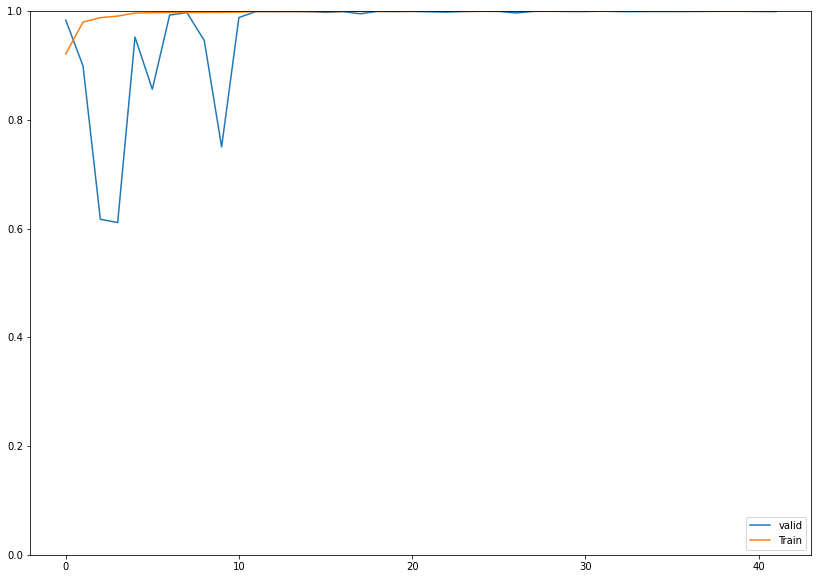

In [34]:
plt.figure(figsize=(14, 10))
plt.plot(history.history["val_accuracy"], label="valid")
plt.plot(history.history["accuracy"], label="Train")
plt.ylim(0.0, 1.0)
plt.legend(loc="lower right")

In [35]:
history.history["val_accuracy"]

[0.98369961977005,
 0.8992673754692078,
 0.6172161102294922,
 0.6111721396446228,
 0.9523809552192688,
 0.8564102649688721,
 0.9928571581840515,
 0.9974358677864075,
 0.9459707140922546,
 0.7503663301467896,
 0.9884615540504456,
 0.9994505643844604,
 0.9994505643844604,
 0.9994505643844604,
 0.9992673993110657,
 0.997802197933197,
 0.9992673993110657,
 0.9952380657196045,
 0.9996336698532104,
 0.9992673993110657,
 0.9996336698532104,
 0.9989010691642761,
 0.9983516335487366,
 0.9994505643844604,
 0.9998168349266052,
 0.9996336698532104,
 0.9967032670974731,
 0.9996336698532104,
 0.9998168349266052,
 0.9994505643844604,
 0.9994505643844604,
 1.0,
 0.9992673993110657,
 0.9992673993110657,
 0.9994505643844604,
 0.9994505643844604,
 0.9994505643844604,
 0.9996336698532104,
 0.9998168349266052,
 0.9998168349266052,
 0.9994505643844604,
 0.9992673993110657]

In [ ]:
his